# CG - Verfahren

## Anwendung

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
import matplotlib.pyplot as plt
from myst_nb import glue

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

In [3]:
fes = H1(mesh, order=1)
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

In [4]:
pre = a.mat.CreateSmoother()

In [5]:
w = f.vec.CreateVector()
r = f.vec.CreateVector()
p = f.vec.CreateVector()
ap = f.vec.CreateVector()

r.data = f.vec
p.data = pre*r
wrn = InnerProduct(r,p)
err0 = sqrt(wrn)
errs = []
gfu.vec[:] = 0

maxit=200
tol=1e-8
its = 0
while True:
    ap.data = a.mat * p

    pap = InnerProduct(p, ap)
    wr = wrn
    alpha = wr / pap

    gfu.vec.data += alpha * p
    r.data -= alpha * ap
    w.data = pre*r

    wrn = InnerProduct(w, r)
    err = sqrt(wrn)
    errs.append(err)
    #print ("Iteration",it,"err=",err)
    if err < tol * err0 or its > 10000: break

    beta = wrn / wr

    p *= beta
    p.data += w
    its += 1
print ("needed", its, "iterations")

needed 46 iterations


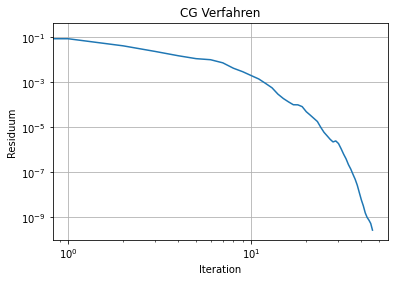

In [6]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('CG Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_CGVerfahren_fig", fig, display=False)